In [1]:
!pip install transformers

In [2]:
!pip install diffusers["torch"] transformers

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast

import PIL
from PIL import Image

In [5]:
# CONSTANTS
HEIGHT = 1024
WIDTH = 1024

BATCH_SIZE = 1

GUIDANCE_SCALE = 5

NUM_INFERENCE_STEPS = 100

GENERATOR = torch.manual_seed(42)

In [6]:
# AutoEncoder to decod latents into Image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
print(vae)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [7]:
# Tokenizer to Tokenize the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [8]:
# Text Encoder to encode the text
encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

In [9]:
#UNet to generate Latents
model = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
print(model)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features

In [10]:
# Define Scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.0009, beta_end=0.002, beta_schedule="scaled_linear")
print(scheduler)

LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.19.3",
  "beta_end": 0.002,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.0009,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "steps_offset": 0,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



In [11]:
vae = vae.to(device)
encoder = encoder.to(device)
model = model.to(device)

In [12]:
PROMPT = ['A man swimming in river on moon']

In [13]:
text_input = tokenizer(PROMPT, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
print(f"Text Input: {text_input}")

with torch.no_grad():
  text_embeddings = encoder(text_input.input_ids.to(device))[0]

print(f"Text Embeddings: {text_embeddings}")

Text Input: {'input_ids': tensor([[49406,   320,   786,  7411,   530,  2473,   525,  3293, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}
Text Embeddings: tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.

In [14]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * BATCH_SIZE, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = encoder(uncond_input.input_ids.to(device))[0]

In [15]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# print(text_embeddings)

In [16]:
# Random Noise
latents = torch.randn(
  (BATCH_SIZE, model.in_channels, HEIGHT // 8, WIDTH // 8),
  generator=GENERATOR,
)
latents = latents.to(device)
# print(latents)
print(latents.shape)

torch.Size([1, 4, 128, 128])


<ipython-input-16-faf70a4615dd>:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (BATCH_SIZE, model.in_channels, HEIGHT // 8, WIDTH // 8),


In [17]:
# Schedule the number of inference steps
scheduler.set_timesteps(NUM_INFERENCE_STEPS)

In [18]:
# K-LMS Scheduler space
latents = latents * scheduler.init_noise_sigma

In [19]:
for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = model(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

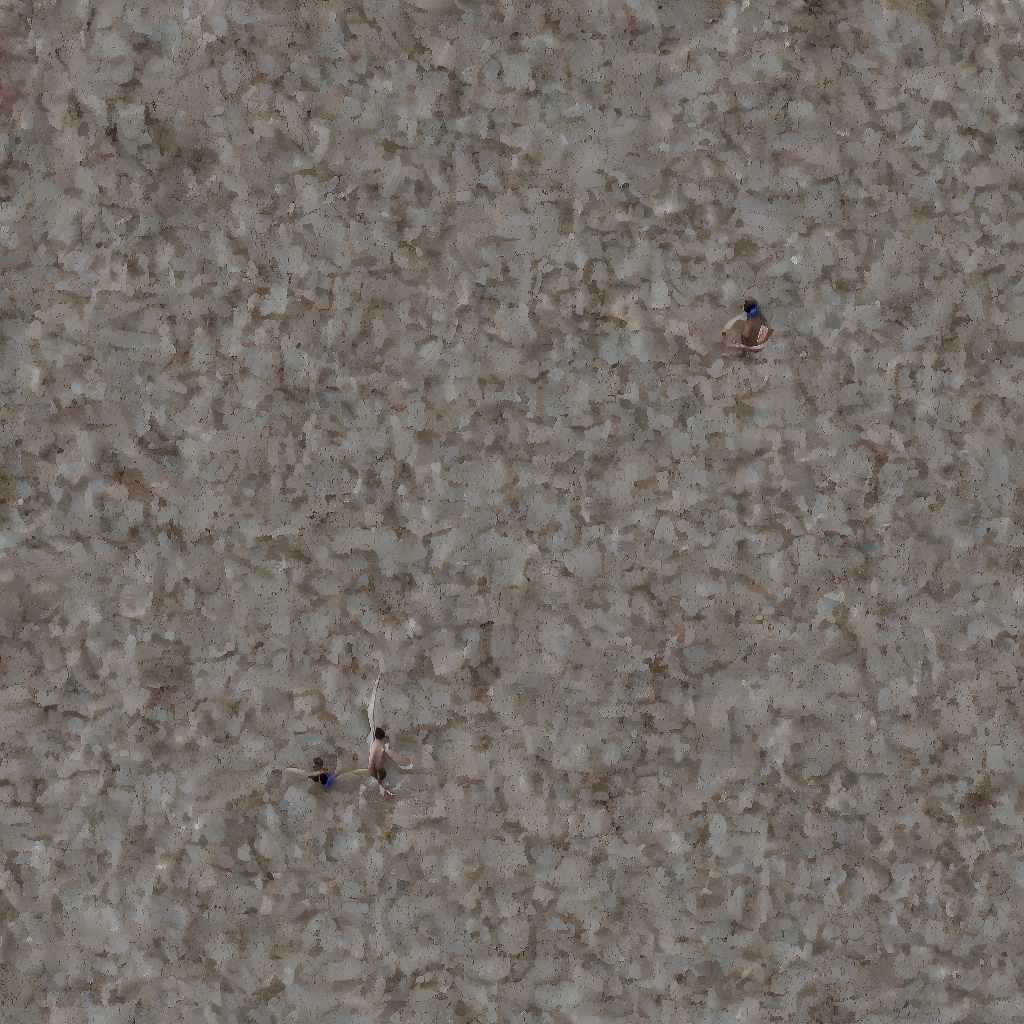

In [21]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]